We begin by setting up the environment and performing all the imports we will need:

In [1]:
!pip install pycm livelossplot albumentations
%pylab inline

You should consider upgrading via the '/opt/firedrake/bin/python -m pip install --upgrade pip' command.
Populating the interactive namespace from numpy and matplotlib


In [2]:
use_albumentations = False

train_whole_model = True
train_last_layer = False
train_some_layers = False

use_googlenet = False
use_resnet50 = False
use_resnet18 = True

In [3]:
from sklearn.metrics import accuracy_score # this allows us to evaluate our model at every iteration
from sklearn.metrics import f1_score # this allows us to evaluate our validation accuracy
from sklearn.model_selection import StratifiedShuffleSplit # this allows us to create a random validation split

# These imports help plot the convergence and create the confusion matrix
from livelossplot import PlotLosses
from pycm import *

# These imports help us create models and datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# This allows me to create my own custom dataset
from torch.utils.data import Dataset 
from torchvision.datasets.folder import *

# This allows me to import pretrained models for transfer learning
import torchvision.models as models

# This allows me to do a number of transforms for data augmentation later on
from torchvision.transforms import Compose, ToTensor, ColorJitter, Resize, Normalize, RandomApply, RandomChoice, RandomRotation, RandomCrop, RandomResizedCrop, RandomHorizontalFlip, RandomAffine, ToPILImage

# These imports help us write the submission file
import json, csv
import os
import os.path

# We will be using albumentations to perform data augmentation
if (use_albumentations):
    from albumentations import Compose
    import albumentations.augmentations.transforms as transforms

# This helps us keep a copy of model state dicts
import copy

# To display random images
from random import randrange

# Enable hardware acceleration
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [4]:
# The means of our entire training set, calculated in another file:
means = [0.4805, 0.4483, 0.3978]
stds = [0.2177, 0.2138, 0.2136]

In [5]:
# Rewritten to help separate data from labels
def my_make_dataset(directory, class_to_idx, extensions=None, is_valid_file=None):
    data = []
    targets = []
    directory = os.path.expanduser(directory)
    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return has_file_allowed_extension(x, extensions)
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    data.append(path)
                    targets.append(class_index)
    return data, targets


# A custom dataset class that will work with albumentations because ImageFolder does not
class AlbumentationImageFolder(ImageFolder):
    def __init__(self, root, extensions=IMG_EXTENSIONS, transform=None,
                 target_transform=None, is_valid_file=None, augmentation=None):
        super(ImageFolder, self).__init__(root, default_loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        
        classes, class_to_idx = self._find_classes(self.root)
        data, targets = my_make_dataset(self.root, class_to_idx, extensions, is_valid_file)
        self.imgs = self.samples
        self.data = [ToTensor()(self.loader(data[i])) for i in range(len(data))]
        self.targets = targets
        self.augmentation = augmentation

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        sample = self.loader(path)
        if self.augmentation is not None:
            sample = self.augmentation(image=np.asarray(sample))['image']
            sample = np.transpose(sample, (2, 0, 1)).astype(np.float32)
            sample = torch.tensor(sample, dtype=torch.float)
            
        return sample, target
    
class CustomImageTensorDatasetNA(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        if self.transform:
            sample = self.transform(sample)
            
        return sample, label
    
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        if self.transform:
            sample = ToPILImage()(sample).convert("RGB")
            sample = self.transform(image=np.array(sample, dtype = np.uint8))['image']
            #sample = np.transpose(sample, (2, 0, 1)).astype(np.float32)
            sample = torch.tensor(sample, dtype=torch.float)

        return sample, label
    
# A custom dataset class that retains filenames for use in creating the csv file
class ImageFolderWithPaths(ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # We only need to override the __getitem__ method
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
my_data = AlbumentationImageFolder("./train/")

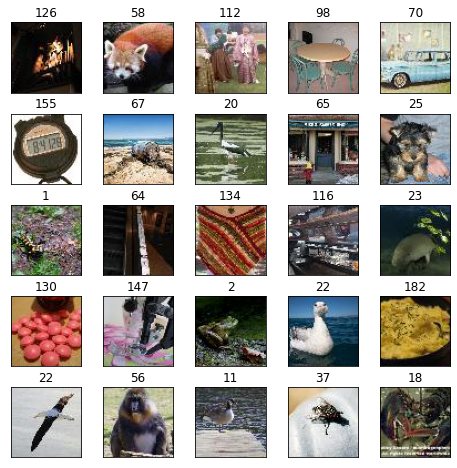

In [7]:
fig, axarr = plt.subplots(5, 5, figsize=(8, 8))
for ax, j in zip(axarr.flatten(), range(25)):
  i = randrange(100000)
  ax.imshow(my_data.data[i].permute(1, 2, 0))
  ax.set_title(my_data.targets[i])
  ax.get_xaxis().set_visible(False) # turn off the axes to improve visibility
  ax.get_yaxis().set_visible(False) # since the axes do not provide useful info
plt.subplots_adjust(hspace=0.3) # increase spaces between the plots to improve visibility
plt.show()

In [8]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1).split(my_data.data, my_data.targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [9]:
my_data.data = torch.stack(my_data.data)

X_train, y_train = my_data.data[indices[0]].float(), torch.from_numpy(np.array(my_data.targets)[indices[0]])
X_val, y_val = my_data.data[indices[1]].float(),  torch.from_numpy(np.array(my_data.targets)[indices[1]])

In [ ]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 100
n_epochs = 30

In [11]:
train_transform = Compose([
    ToPILImage(),
    RandomApply([RandomChoice([RandomCrop(size=[64, 64], padding=4), RandomAffine(0, translate=(0.1, 0.1))])]),
    RandomHorizontalFlip(),
    Resize(224),
    ToTensor(),
    Normalize(mean=means, std=stds), 
])

validation_test_transform = Compose([
    ToPILImage(),
    Resize(224),
    ToTensor(),
    Normalize(mean=means, std=stds)
])

In [ ]:
if (use_albumentations):
    data_train = CustomImageTensorDataset(X_train, y_train.long(), transform=Compose([
                        transforms.RandomContrast(),
                        transforms.HorizontalFlip(),
                        transforms.HueSaturationValue(),
                        transforms.Resize(224, 224),
                        transforms.Normalize(means, stds)
                        ]))
    data_validate = CustomImageTensorDataset(X_val, y_val.long(), transform=Compose([transforms.Resize(224, 224),
                        transforms.Normalize(means, stds)]))

else:
    data_train = CustomImageTensorDatasetNA(X_train, y_train.long(), transform=train_transform)
    data_validate = CustomImageTensorDatasetNA(X_val, y_val.long(), transform=validation_test_transform)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(data_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


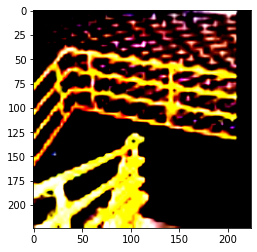

In [15]:
plt.imshow(data_train[137][0].permute(1, 2, 0))

In [16]:
print(ToPILImage()(data_train.data[0]).convert("RGB"))

<PIL.Image.Image image mode=RGB size=64x64 at 0x7F36BCD6B080>


In [17]:
# Trains our model on the training set
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
# Checks our model against the validation set
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
# Evaluates our model's % accuracy
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

# Generates predictions in the required format
def predict(model, data_loader):
    model.eval()
    files, y_preds = [], []
    for X, y, z in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_preds.append(y_pred.cpu().numpy())
            files.append(z)
            
    return np.concatenate(y_preds, 0), np.concatenate(files, 0)

# Generates predictions by averaging two models
def multimodel_predict(model_first, model_second, data_loader):
    model_first.eval()
    model_second.eval()
    files, y_preds = [], []
    for X, y, z in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model_first(X.view(-1, 3, 224, 224))
            a3 = model_second(X.view(-1, 3, 224, 224))
            a2 = (a2 + a3) / 2.
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_preds.append(y_pred.cpu().numpy())
            files.append(z)
            
    return np.concatenate(y_preds, 0), np.concatenate(files, 0)

# Generates predictions by averaging 3 models
def threemodel_predict(model_first, model_second, model_third, data_loader):
    model_first.eval()
    model_second.eval()
    model_third.eval()
    files, y_preds = [], []
    for X, y, z in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model_first(X.view(-1, 3, 224, 224))
            a3 = model_second(X.view(-1, 3, 224, 224))
            a4 = model_third(X.view(-1, 3, 224, 224))
            a2 = (a2 + a3 + a4) / 3.
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_preds.append(y_pred.cpu().numpy())
            files.append(z)
            
    return np.concatenate(y_preds, 0), np.concatenate(files, 0)

# Checks the accuracy of our 3 model evaluation
def threemodel_evaluate(model_first, model_second, model_third, data_loader):
    model_first.eval()
    model_second.eval()
    model_third.eval()
    files, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model_first(X.view(-1, 3, 224, 224))
            a3 = model_second(X.view(-1, 3, 224, 224))
            a4 = model_third(X.view(-1, 3, 224, 224))
            a2 = (a2 + a3 + a4) / 3.
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0)

In [18]:
if (use_googlenet):
    model = models.googlenet(pretrained=True).to(device)
elif (use_resnet18):
    model = models.resnet18(pretrained=True).to(device)
else:
    model = models.resnet50(pretrained=True).to(device)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200) # change number of output classes

# uncomment to load previously created model:
# model.load_state_dict(torch.load("./Googlenet_full_barely_augmented.pth"))

In [19]:
if (train_some_layers):
    ct = 0
elif (train_last_layer):
    ct = -100
else:
    ct = 12
    
for child in model.children():
    ct += 1
    if ct < 12:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True
            
print(ct)

if (train_last_layer):
    for param in model.fc.parameters():
        param.requires_grad = True

22


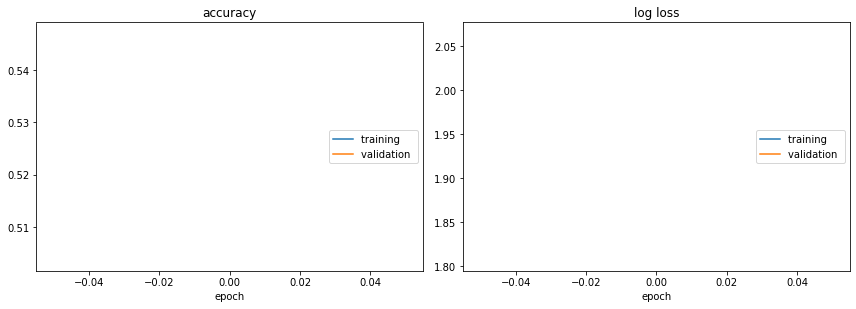

accuracy
	training         	 (min:    0.504, max:    0.504, cur:    0.504)
	validation       	 (min:    0.547, max:    0.547, cur:    0.547)
log loss
	training         	 (min:    2.064, max:    2.064, cur:    2.064)
	validation       	 (min:    1.807, max:    1.807, cur:    1.807)


In [ ]:
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(40):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    if validation_accuracy.item() > best_acc:
        best_acc = validation_accuracy.item()
        best_model_wts = copy.deepcopy(model.state_dict())
    
    liveloss.update(logs)
    liveloss.draw()

In [ ]:
y_pred, y_true = evaluate(model, validation_loader)

f1 = f1_score(y_true, y_pred, average="macro")
print(f1)

In [ ]:
my_predictions, my_files = predict(model, test_loader)

my_files_clean = [my_files[i][14:] for i in range(len(my_files))]

with open('submission_1.csv', 'w', encoding="ISO-8859-1", newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(("Filename", "Label"))
    wr.writerows(zip(my_files_clean,my_predictions))

In [ ]:
# Change your model name:
model_save_name = 'Model_name.pth'
path = F"./{model_save_name}" 
torch.save(model.state_dict(), path)